# Downloading dataset

I have downloaded the dataset manually and uploaded it in the input section of kaggle notebook.

Dataset can be downloaded here: https://storage.googleapis.com/wandb_datasets/nature_12K.zip

# Part A: Training from scratch

## Question 1

### computing the shape of input images, so that we can design CNN accordingly

In [1]:
from PIL import Image
import numpy as np

img_1 = Image.open('/kaggle/input/inaturalist-12k/inaturalist_12K/train/Amphibia/0012ec13b97dfbfb3dd5de8c3da95555.jpg')

img_array = np.array(img_1)

print(f'shape of input image is {img_array.shape}')

shape of input image is (600, 800, 3)


### Building 5 layer CNN model 

In [2]:
# Importing libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import wandb
import torchvision.transforms as T
from pytorch_lightning.loggers import WandbLogger

In [3]:

# Building a class for CNN model
class CNNLightningModel(pl.LightningModule):
    def __init__(
        self,
        input_size=(600, 800, 3),
        num_classes=20,
        conv_channels=[16, 32, 64],
        kernel_sizes=[3, 3, 3],
        activation_fn="ReLU",
        dense_neurons=512,
        max_pool_size=2,
        learning_rate=1e-3,
        batch_norm=False,
        dropout=0.2,
    ):
        super(CNNLightningModel, self).__init__()
        self.save_hyperparameters()
        # Map activation function
        activation_map = {
            "ReLU": nn.ReLU,
            "GELU": nn.GELU,
            "SiLU": nn.SiLU,
            "Mish": nn.Mish,
        }
        act_fn = activation_map[activation_fn]
        self.act_fn = act_fn()
        
        self.conv_layers = nn.ModuleList()
        in_channels = input_size[2]
        for out_channels, kernel_size in zip(conv_channels, kernel_sizes):
            layers = [
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                )
            ]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(act_fn())
            layers.append(nn.MaxPool2d(kernel_size=max_pool_size))
            if dropout > 0:
                layers.append(nn.Dropout2d(dropout/2))  # Lower dropout for conv layers
            self.conv_layers.append(nn.Sequential(*layers))
            in_channels = out_channels
            
        # Calculate flattened size
        height, width = input_size[0], input_size[1]
        for _ in range(len(conv_channels)):
            height //= max_pool_size
            width //= max_pool_size
        flatten_size = conv_channels[-1] * height * width
        
        self.fc1 = nn.Linear(flatten_size, dense_neurons)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(dense_neurons, num_classes)
        self.learning_rate = learning_rate
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.act_fn(self.fc1(x))
        x = self.dropout(x)
        return self.fc_out(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True, logger=True)
        return {"val_loss": loss, "val_acc": acc}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss"
        }

In [4]:
model = CNNLightningModel(batch_norm=True, activation_fn="GELU")

print(model)

CNNLightningModel(
  (act_fn): GELU(approximate='none')
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.1, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

## Question 2

In [5]:
# importing libraries

import os
import shutil
from sklearn.model_selection import train_test_split

In [6]:
data_dir = '/kaggle/input/inaturalist-12k/inaturalist_12K/train'
new_val_dir = 'val_for_tuning'
new_train_dir = 'train_for_tuning'
os.makedirs(new_val_dir, exist_ok=True)
os.makedirs(new_train_dir, exist_ok=True)

In [7]:
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir,class_name)

    # error handling in case the class_path does not exist
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, val_imgs = train_test_split(images,test_size=0.2, random_state=42)

    # create a new directory for storing val_imgs
    os.makedirs(os.path.join(new_val_dir, class_name), exist_ok = True)
    os.makedirs(os.path.join(new_train_dir, class_name), exist_ok = True)

    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_val_dir, class_name, img))

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_train_dir, class_name, img))

The above code will create two folders inside output directory of kaggle as follows
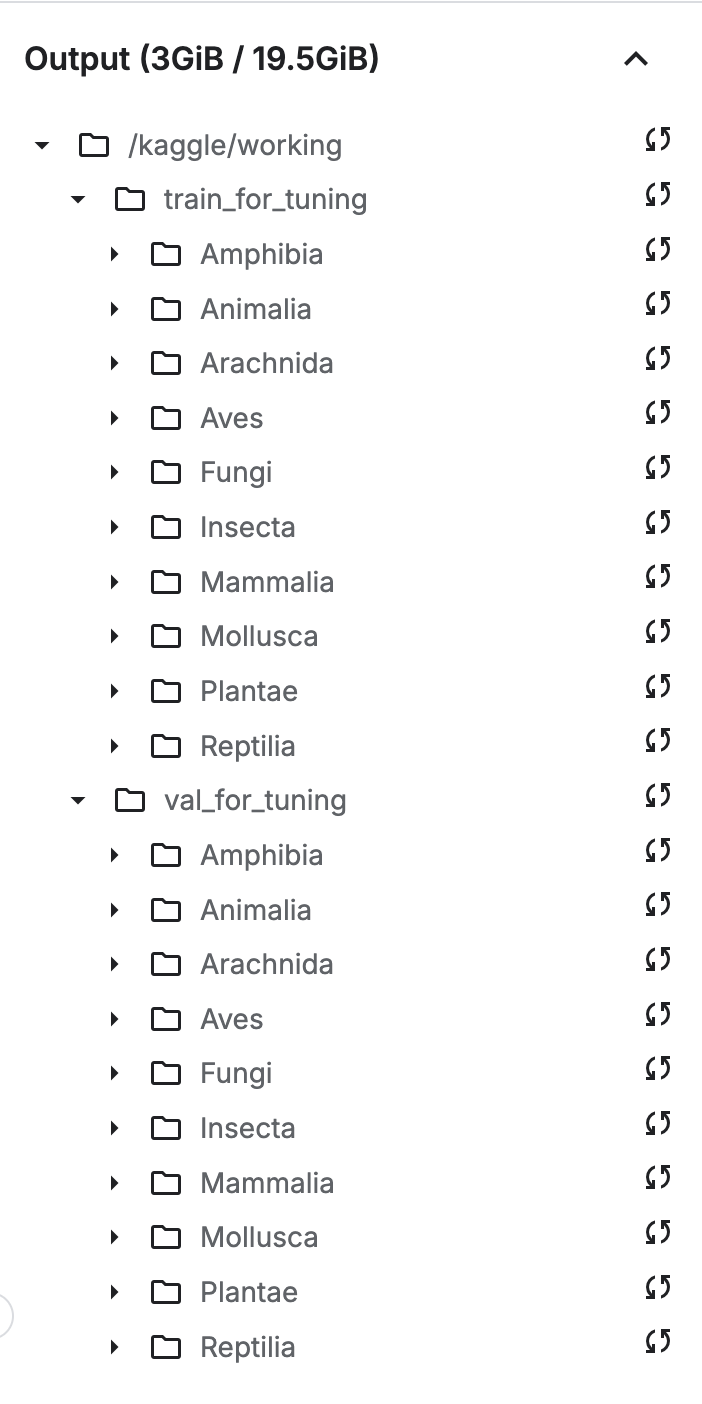
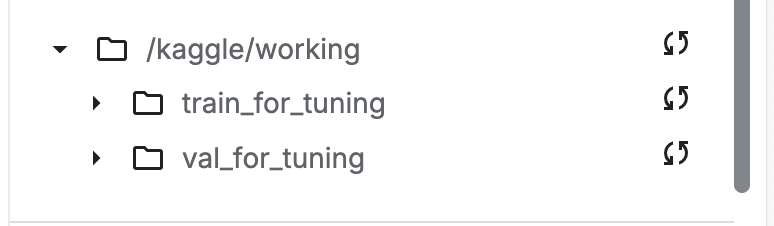

In [8]:
# storing wandb api key in secrets

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")

In [9]:
# setting up wandb

!pip -q install wandb --upgrade
import wandb
wandb.login(key=secret_value_0)

print(wandb.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 91.7 MB/s eta 0:00:00


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m007 (da24m007-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


0.19.6


In [10]:
# Set up wandb logger with python lightning

from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project='DL-A2-V2')

In [11]:
# Data augmentation transforms
def get_transforms(data_augmentation=False):
    IMAGE_SIZE = (224, 224) 
    if data_augmentation:
        return T.Compose([
            T.Resize(IMAGE_SIZE),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=15),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            T.ToTensor(),
            T.Normalize(mean=[0.5]*3, std=[0.5]*3)  # normalize to [-1, 1]
        ])
    return T.Compose([
        T.Resize(IMAGE_SIZE),
        T.ToTensor(),
        T.Normalize(mean=[0.5]*3, std=[0.5]*3)  # normalize to [-1, 1]
    ])

In [12]:
# Training function for sweep
def train_sweep():
    run = wandb.init()
    config = wandb.config

    print(config)

    
    train_dataset = datasets.ImageFolder(root=new_train_dir, transform=get_transforms(bool(config.data_augmentation)))
    val_dataset = datasets.ImageFolder(root=new_val_dir, transform=get_transforms(bool(config.data_augmentation)))
    # train_dataset = datasets.ImageFolder(root=new_train_dir, transform=get_transforms(Tr))
    # val_dataset = datasets.ImageFolder(root=new_val_dir, transform=get_transforms())


    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
    )

    # Initialize model
    model = CNNLightningModel(
        input_size=(224, 224, 3),
        conv_channels=config.conv_channels,
        kernel_sizes=[3] * len(config.conv_channels),
        activation_fn=config.activation_fn,
        dense_neurons=512,
        max_pool_size=2,
        learning_rate=config.learning_rate,
        batch_norm=config.batch_norm,
        dropout=config.dropout,
    )

    # Trainer
    trainer = pl.Trainer(
        max_epochs=5,  # Reduced for faster sweeps
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        logger=WandbLogger(),
        enable_checkpointing=False,
    )

    # Train and validate
    trainer.fit(model, train_dataloader, val_dataloader)

    # Finish run
    run.finish()

# Sweep configuration
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "conv_channels": {
            "values": [
                [32, 32, 32],
                [64, 64, 64],
                [16, 32, 64],
                [32, 64, 128],
                [64, 32, 16],  # Halving channels
                [32, 64, 64], 
                [64, 128, 256],  # Doubling channels
                [128, 64, 32]   # Decreasing channels
            ]
        },
        "activation_fn": {"values": ["ReLU", "GELU", "SiLU", "Mish"]},
        "data_augmentation": {"values": [True, False]},
        "batch_norm": {"values": [True, False]},
        "dropout": {"values": [0.0, 0.2, 0.3, 0.4]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 1e-2},
        "batch_size": {"values": [16, 32, 64]},
    },
}

In [13]:
# Initialize and run sweep
sweep_id = wandb.sweep(sweep_config, project = 'DL-A2-V2')
wandb.agent(sweep_id, function=train_sweep, count=20) 

Create sweep with ID: dv1x5m58
Sweep URL: https://wandb.ai/da24m007-iit-madras/DL-A2-V2/sweeps/dv1x5m58


wandb: Agent Starting Run: gx88pzjs with config:
wandb: 	activation_fn: ReLU
wandb: 	batch_norm: False
wandb: 	batch_size: 32
wandb: 	conv_channels: [64, 64, 64]
wandb: 	data_augmentation: False
wandb: 	dropout: 0
wandb: 	learning_rate: 0.00012115567159608948
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: ERROR Run gx88pzjs errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_19/122943439.py", line 3, in train_sweep
wandb: ERROR     run = wandb.init()
wandb: ERROR           ^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1485, in init
wandb: ERROR     )
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py", line 156, in reraise
wandb: ERROR     ra

wandb: 
wandb: 🚀 View run  at: https://wandb.ai/da24m007-iit-madras/DL-A2-V2/runs/gx88pzjs
wandb: Find logs at: wandb/run-20250417_034717-gx88pzjs/logs


wandb: ERROR Run 8nahheiq errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_19/122943439.py", line 3, in train_sweep
wandb: ERROR     run = wandb.init()
wandb: ERROR           ^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1485, in init
wandb: ERROR     )
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py", line 156, in reraise
wandb: ERROR     raise exc.with_traceback(sys.exc_info()[2])
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1471, in init
wandb: ERROR     wl: wandb_setup._WandbSetup | None = None
wandb: ERROR                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 807, in init

wandb: 
wandb: 🚀 View run  at: https://wandb.ai/da24m007-iit-madras/DL-A2-V2/runs/8nahheiq
wandb: Find logs at: wandb/run-20250417_034723-8nahheiq/logs


wandb: ERROR Run oghm93q9 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_19/122943439.py", line 3, in train_sweep
wandb: ERROR     run = wandb.init()
wandb: ERROR           ^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1485, in init
wandb: ERROR     )
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/analytics/sentry.py", line 156, in reraise
wandb: ERROR     raise exc.with_traceback(sys.exc_info()[2])
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 1471, in init
wandb: ERROR     wl: wandb_setup._WandbSetup | None = None
wandb: ERROR                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_init.py", line 807, in init